In [1]:
from __init__ import *

In [2]:
for data in SETTING["model_data_"]:

    df = pd.read_csv(data["file_path"], sep="\t", index_col=0)

    df.columns.name = data["axis_1_name"]

    data["df"] = df

In [3]:
for data in SETTING["model_data_"]:

    df = data["df"]

    matrix = df.to_numpy()

    axis_0_label_ = df.index.to_numpy()

    axis_1_label_ = df.columns.to_numpy()

    axis_0_name = df.index.name

    axis_1_name = df.columns.name

    assert (0 <= matrix).all()

    sum_ = np.sum(matrix, axis=0)

    assert (0 < sum_).all()

    for row in matrix:

        is_ = 0 < row

        row_is_ = row[is_]

        sum_is_ = sum_[is_]

        for index, signal in enumerate(
            kraft.information.get_kld(row_is_ / row_is_.sum(), sum_is_ / sum_is_.sum())
        ):

            row[index] = signal

#     kraft.df.summarize(df)

In [7]:
def isolate(matrix, axis_0_label_, signal):

    if signal == "-":

        matrix = matrix.clip(max=0)

        direction = "<"

    elif signal == "+":

        matrix = matrix.clip(min=0)

        direction = ">"

    median_ = np.median(matrix, axis=1)

    index_ = np.argsort(median_)

    median_ = median_[index_]

    matrix = matrix[index_]

    axis_0_label_ = axis_0_label_[index_]

    is_ = kraft.array.check_is_extreme(median_, direction, standard_deviation=2)

    median_is_ = median_[is_]

    matrix_is = matrix[is_]

    axis_0_label_is_ = axis_0_label_[is_]

    kraft.plot.plot_plotly(
        {
            "data": [
                {
                    "name": "All ({})".format(median_.size),
                    "y": median_,
                    "x": axis_0_label_,
                },
                {
                    "name": "Extreme ({})".format(median_is_.size),
                    "y": median_is_,
                    "x": axis_0_label_is_,
                    "mode": "markers",
                },
            ],
            "layout": {
                "yaxis": {"title": {"text": "Median {} signal".format(signal)}},
                "xaxis": {"title": {"text": "Rank"}},
            },
        }
    )

    return matrix_is, axis_0_label_is_

In [8]:
directory_path = "../output/signal/"

kraft.path.make(directory_path)

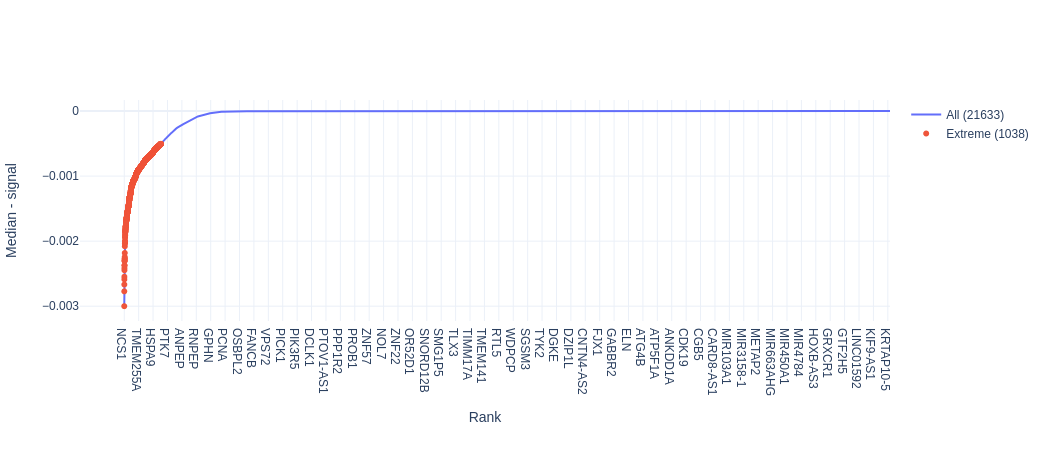

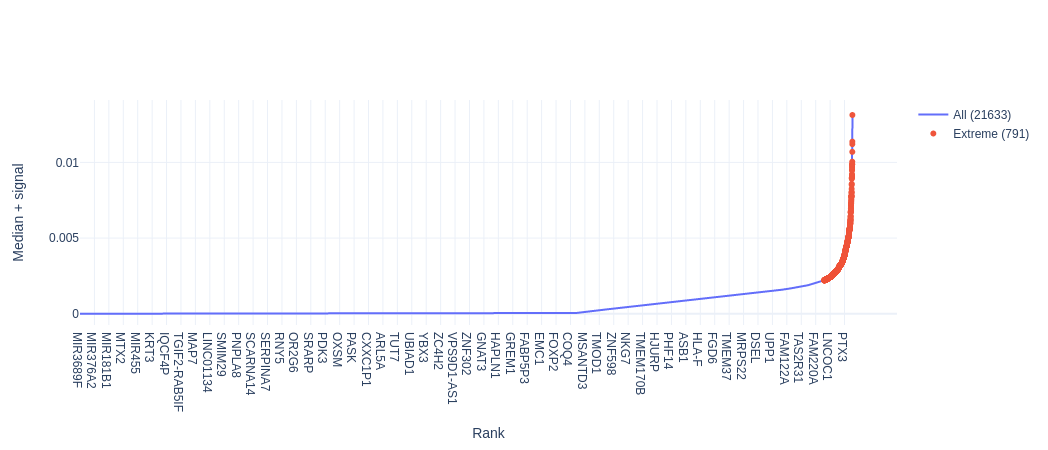

In [9]:
for index, data in enumerate(SETTING["model_data_"]):

    df = data["df"]

    matrix = df.to_numpy()

    axis_0_label_ = df.index.to_numpy()

    axis_1_label_ = df.columns.to_numpy()

    axis_0_name = df.index.name

    axis_1_name = df.columns.name

    negative_matrix, negative_axis_0_label_ = isolate(matrix, axis_0_label_, "-")

    positive_matrix, positive_axis_0_label_ = isolate(matrix, axis_0_label_, "+")

    kraft.pd.summarize(
        pd.DataFrame(
            data=negative_matrix,
            index=pd.Index(data=negative_axis_0_label_,name=axis_0_name),
            columns=pd.Index(data=axis_1_label_,name=axis_1_name),
        )
    )

    kraft.pd.summarize(
        pd.DataFrame(
            data=positive_matrix,
            index=pd.Index(data=positive_axis_0_label_,name=axis_0_name),
            columns=pd.Index(data=axis_1_label_,name=axis_1_name),
        )
    )

    if SETTING["signal"] == "-+":

        signal_axis_0_label_ = np.concatenate(
            (
                np.asarray(
                    tuple("-{}".format(label) for label in negative_axis_0_label_)
                ),
                np.asarray(
                    tuple("+{}".format(label) for label in positive_axis_0_label_)
                ),
            )
        )

        signal_matrix = np.concatenate((negative_matrix, positive_matrix))

    elif SETTING["signal"] == "-":

        signal_axis_0_label_ = negative_axis_0_label_

        signal_matrix = negative_matrix

    elif SETTING["signal"] == "+":

        signal_axis_0_label_ = positive_axis_0_label_

        signal_matrix = positive_matrix

    signal_df = pd.DataFrame(
        data=signal_matrix,
        index=pd.Index(data=signal_axis_0_label_,name=axis_0_name),
        columns=pd.Index(data=axis_1_label_,name=axis_1_name),
    )

    kraft.pd.summarize(signal_df)

    signal_df.to_csv("{}{}.tsv".format(directory_path, index), sep="\t")